# Cognitive Services Personalizer

This tutorial simulates a Multislot Personalizer loop _system_ which suggests which products a customer should buy when displayed in different slots. The users and their preferences are store in a [user dataset](simulated_users.json). Information about the products is also available in a [product dataset](products.json). Information about the slots is also available in a [slot dataset](slots.json).

A summary of the user information is:

|Customers|Days of month|Times of Day|Types of Device|
|--|--|--|--|
|Alice<br>Bob<br>Cathy|7<br>21<br>30|Morning<br>Afternoon<br>Evening|Desktop<br>Mobile|

To help Personalizer make the correct product selection for each person, the _system_ also knows details about the product.

|Product on Sale|Price|Category|
|--|--|--|
|true<br>false|20<br>70<br>200<br>499|Clothing<br>Sports<br>Electronics|

The _system_ also knows details about the slots where the recommended products will be displayed.

|Size|Position|
|--|--|
|Large<br>Small|Left<br>Right|

The **purpose** of the Personalizer loop is to find the best match between the users and the product as much of the time as possible.

## How the simulation works

At the beginning of the running system, the suggestions from Personalizer are only successful between 20% to 30% (indicated by the reward score of 1). After some requests, the system improves.

After the initial 20,000 requests, run an offline evaluation. This allows Personalizer to review the data and suggest a better learning policy. Apply the new learning policy and run the notebook again with 5,000 requests. The loop will perform better.

## Multislot Rank and Reward calls
For each of the few thousand calls to the Personalizer service, the Azure notebook sends the **Multislot Rank** request to the REST API:
* A unique ID for the Multislot Rank/Request event
* Context - A random choice of the user, day of month, time of day, and device - simulating a user on a website or mobile device 
* Features - All the product data - from which Personalizer makes a suggestion 
* Slots - All the slot information where the recommended products will be displayed

The system receives the Multislot rank of the product choices, then compares that prediction with the user's known choice for the same day of month, time of day and device. If the known choice is the same as the prediction choice, the **Reward** of 1 is sent back to Personalizer. Otherwise the reward is 0. 

> [!Note]
> This is a simulation so the algorithm for the reward is simple. In a real-world scenario, the algorithm should use business logic, possibly with weights for various aspects of the customer's experience, to determine the reward score.

## Prerequisites
* An [Azure Personalizer resource](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesPersonalizer).
* If you have already used the Personalizer resource, make sure to [clear the data](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/how-to-settings#clear-data-for-your-learning-loop) in the Azure portal for the resource.
* Upload all the files for this sample into an Azure Notebook project.


File descriptions:

* [MultislotPersonalizer.ipynb](MultislotPersonalizer.ipynb) is the Jupyter notebook for this tutorial.
* [User dataset](simulated_users.json) is stored in a JSON object.
* [Product dataset](products.json) is stored in a JSON object.
* [Slot dataset](slots.json) is stored in a JSON object.
* [Example Request JSON](example-rankrequest.json) is the expected format for a POST request to the Rank API.

## Configure Personalizer resource
    
In the Azure portal, configure your [Personalizer resource](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesPersonalizer) with the **update model frequency** set to 15 seconds and a **reward wait time** of 15 seconds. These settings are found in the Configurations tab, under the RESOURCE MANAGEMENT section.    

|Setting|Value|
|--|--|
|update model frequency|15 seconds|
|reward wait time|15 seconds|    

These values have a very short duration in order to show changes in this tutorial. These values shouldn't be used in a production scenario without validating they achieve your goal with your Personalizer loop.

## Set up the Azure Notebook 
Change the Kernel to Python 3.6

## Run Notebook cells
Run each executable cell and wait for it to return.

You know it is done when the brackets next to the cell display a number instead of a `*`. Do not continue if you get an error.

The following sections explain what each cell does programmatically and what to expect for the output.

### Include the python modules
Include the required python modules. The cell has no output.

In [163]:
import json
import matplotlib.pyplot as plt
import random
import requests
import time
import uuid
import datetime

### Set Personalizer resource key and name

From the Azure portal, find your key and endpoint on the **Quickstart** page of your Personalizer resource. Change the value of `<your-resource-name>` to your Personalizer resource's name. Change the value of `<your-resource-key>` to your Personalizer key. 

The cell has no output.

In [168]:
# Replace 'personalization_base_url' and 'resource_key' with your valid endpoint values.
personalization_base_url = "https://<your-resource-name>.cognitiveservices.azure.com/"
resource_key = "<your-resource-key>"

### Print current date and time
Use this function to note the start and end times of the iterative function, `iterations`.

These cells have no output. The function does output the current date and time when called.

In [135]:
# Print out current datetime
def currentDateTime():
    currentDT = datetime.datetime.now()
    print (str(currentDT))

### Get the last model update date and time

When the function, `get_last_updated`, is called, the function prints out the last modified date and time that the model was updated. 

These cells have no output. The function does output the last model training date when called.

The function uses a GET REST API to [get model properties](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/GetModelProperties). 

In [164]:
# initialize variable for model's last modified date
modelLastModified = ""

In [165]:
def get_last_updated(currentModifiedDate):

    print('-----checking model')

    # get model properties
    response = requests.get(personalization_model_properties_url, headers = headers, params = None)

    print(response)
    print(response.json())

    # get lastModifiedTime
    lastModifiedTime = json.dumps(response.json()["lastModifiedTime"])

    if (currentModifiedDate != lastModifiedTime):
        currentModifiedDate = lastModifiedTime
        print(f'-----model updated: {lastModifiedTime}')

### Get policy and service configruation

Validate the state of the service with these two REST calls.

These cells have no output. The function does output the service settings when called.

In [166]:
def get_service_settings():

    print('-----checking service settings')

    # get learning policy
    response = requests.get(personalization_model_policy_url, headers = headers, params = None)

    print(response)
    print(response.json())

    # get service settings
    response = requests.get(personalization_service_configuration_url, headers = headers, params = None)

    print(response)
    print(response.json())

### Construct URLs for REST calls and read JSON data files

This cell 

* builds the URLs used in REST calls 
* sets the security header using your Personalizer resource key 
* sets the random seed for the Rank event ID
* reads in the JSON data files
* calls `get_last_updated` method - learning policy has been removed in example output
* calls `get_service_settings` method

The cell has output from the call to `get_last_updated` and `get_service_settings` functions.

In [170]:
# build URLs
personalization_rank_url = personalization_base_url + "personalizer/v1.1-preview.1/multislot/rank"
personalization_reward_url = personalization_base_url + "personalizer/v1.1-preview.1/multislot/events/" #add "{eventId}/reward"
personalization_model_properties_url = personalization_base_url + "personalizer/v1.1-preview.1/model/properties"
personalization_model_policy_url = personalization_base_url + "personalizer/v1.1-preview.1/configurations/policy"
personalization_service_configuration_url = personalization_base_url + "personalizer/v1.1-preview.1/configurations/service"
headers = {'Ocp-Apim-Subscription-Key': resource_key, 'Content-Type': 'application/json'}

# context
users = "simulated_users.json"

# action features
products = "products.json"

# slot features
slots = "slots.json"

# empty JSON for Rank request
requestpath = "example-rankrequest.json"

# initialize random
random.seed(time.time())

simulated_users = None
rankactionsjsonobj = None
actionfeaturesobj = None
slotfeaturesobj = None

with open(users) as handle:
    simulated_users = json.loads(handle.read())

with open(products) as handle:
    actionfeaturesobj = json.loads(handle.read())

with open(slots) as handle:
    slotfeaturesobj = json.loads(handle.read())

with open(requestpath) as handle:
    rankactionsjsonobj = json.loads(handle.read())

get_last_updated(modelLastModified)
get_service_settings()

print(f'Users count {len(simulated_users)}')
print(f'Products count {len(actionfeaturesobj)}')
print(f'Slots count {len(slotfeaturesobj)}')

Users count 3
Products count 4
Slots count 2


### Troubleshooting the first REST call

This previous cell is the first cell that calls out to Personalizer. Make sure the REST status code in the output is `<Response [200]>`. If you get an error, such as 404, but you are sure your resource key and name are correct, reload the notebook.

Make sure the count of users, products and slots are 3, 4 and 2 respectively. If you get an error, check that you uploaded all 4 JSON files. 

### Set up metric chart in Azure portal

Later in this tutorial, the long running process of 20,000 requests is visible from the browser with an updating text box. It may be easier to see in a chart or as a total sum, when the long running process ends. To view this information, use the metrics provided with the resource. You can create the chart now that you have completed a request to the service, then refresh the chart periodically while the long running process is going.

1. In the Azure portal, select your Personalizer resource.
1. In the resource navigation, select **Metrics** underneath Monitoring. 
1. In the chart, select **Add metric**.
1. The resource and metric namespace are already set. You only need to select the metric of **successful calls** and the aggregation of **sum**.
1. Change the time filter to the last 4 hours.

    You should see three successful calls in the chart. 

### Generate a unique event ID
This function generates a unique ID for each rank call. The ID is used to identify the rank and reward call information. This value could come from a business process such as a web view ID or transaction ID.

The cell has no output. The function does output the unique ID when called.

In [140]:
def add_event_id(rankjsonobj):
    eventid = uuid.uuid4().hex
    rankjsonobj["eventId"] = eventid
    return eventid

### Get random user, day of month, time of day and device 

This function selects a unique user, day of month, time of day, and device, then adds those items to the JSON object to send to the Multislot Rank request. 

The cell has no output. When the funciton is called it returns the random user's name, random day of month, random time of day and random device. 

The list of 3 users and their preferences - only some preferences are shown for brevity:

```json
{
	"Alice": {
		"7": {
			"Morning": {
				"Desktop": {
					"BigHeroPosition": [],
					"SmallSidebar": ["Tennis-Racket-133"]
				}...
			}
		}
	},
	"Bob": {
		"7": {
			"Morning": {
				"Desktop": {
					"BigHeroPosition": [],
					"SmallSidebar": []
				}...
			}
		}
	},
	"Cathy": {
		"7": {
			"Morning": {
				"Desktop": {
					"BigHeroPosition": ["Red-Polo-Shirt-432"],
					"SmallSidebar": []
				}...				
			}
		}
	}
}
```

In [141]:
def add_random_user_and_contextfeatures(namesopt, dayofmonthopt, timeofdayopt, deviceopt, rankjsonobj):
    name = namesopt[random.randint(0,2)]
    dayofmonth = dayofmonthopt[random.randint(0,2)]
    timeofday = timeofdayopt[random.randint(0,2)]
    device = deviceopt[random.randint(0,1)]
    rankjsonobj['contextFeatures'] = [{'name': name, 'dayofmonth': dayofmonth, 'timeofday': timeofday, 'device': device}]
    return [name, dayofmonth, timeofday, device]

### Add all product data 

This functions adds the entire list of product to the JSON object to send to the Multislot Rank request. 

The cell has no output. The function does change the rankjsonobj when called.

The example of a single product's features is:

```json
{
    "id": "Red-Polo-Shirt-432",
	"features": [{
		"onSale": true,
		"price": 20,
		"category": "Clothing"
	}]
}
```


In [142]:
def add_action_features(rankjsonobj):
    rankjsonobj['actions'] = actionfeaturesobj

### Add all slot data 

This function adds the entire list of slot to the JSON object to send to the Multislot Rank request.

The cell has no output. The function does change the rankjsonobj when called. 

The example of a single slot's feature is:

```json
{
	"id": "BigHeroPosition",
	"features": [{
		"size": "large",
		"position": "left"
	}],
	"baselineAction": "Red-Polo-Shirt-432"
}
```

In [143]:
def add_slot_features(rankjsonobj):
    rankjsonobj['slots'] = slotfeaturesobj

### Compare Multislot Rank API's prediction with known user preference

This function is called after the Multislot Rank API is called, for each iteration.

This function compares the user's preferences for product, based on day of month, time of day and device, with the Personalizer's suggestion for the user for those filters. If the suggestion matches, a score of 1 is returned, otherwise the score is 0. The cell has no output. The function does output the score when called. 

In [144]:
def get_reward_from_simulated_data(name, dayofmonth, timeofday, device, slotId, prediction):
    if(prediction in str(simulated_users[name][dayofmonth][timeofday][device][slotId])):
        return 1
    return 0

### Loop through the calls to Multislot Rank and Reward

The next cell is the _main_ work of the Notebook, getting a random user, getting the product list, getting the slot list, sending both to the Multislot Rank API. Comparing the prediction with the user's known preferences, then sending the reward back to the Personalizer service. 

The loop runs for the `num_requests` times. Personalizer needs a few thousand calls to Multislot Rank and Reward to create a model. 

An example of the JSON sent to the Multislot Rank API follows. The list of product is not complete, for brevity. You can see the entire JSON for product in `products.json`.

```json
{
	'contextFeatures': [
		{
			'name': 'Bob', 
			'dayofmonth': '21', 
			'timeofday': 'Afternoon', 
			'device': 'Mobile'
		}
    ], 
	'actions': [
		{
			'id': 'Red-Polo-Shirt-432', 
			'features': [
				{
					'onSale': True, 
					'price': 20, 
					'category': 'Clothing'
				}
			]
		}
		...rest of product list
	], 
	'slots': [
		{
			'id': 'BigHeroPosition', 
			'features': [
				{
					'size': 'large', 
					'position': 'left'
				}
			], 
			'baselineAction': 'Red-Polo-Shirt-432'
		}
		...rest of slot list
	], 	
	'eventId': '3a4d7635ebff45f3b32cff81b119010b', 
	'deferActivation': False
}
```

Json sent to the Multislot Rank API:
```console
{'contextFeatures': [{'name': 'Bob', 'dayofmonth': '21', 'timeofday': 'Afternoon', 'device': 'Mobile'}], 'actions': [{'id': 'Red-Polo-Shirt-432', 'features': [{'onSale': True, 'price': 20, 'category': 'Clothing'}]}, {'id': 'Tennis-Racket-133', 'features': [{'onSale': False, 'price': 70, 'category': 'Sports'}]}, {'id': '31-Inch-Monitor-771', 'features': [{'onSale': True, 'price': 200, 'category': 'Electronics'}]}, {'id': 'XBox-Series X-117', 'features': [{'onSale': False, 'price': 499, 'category': 'Electronics'}]}], 'slots': [{'id': 'BigHeroPosition', 'features': [{'size': 'large', 'position': 'left'}], 'baselineAction': 'Red-Polo-Shirt-432'}, {'id': 'SmallSidebar', 'features': [{'size': 'small', 'position': 'right'}], 'baselineAction': 'Tennis-Racket-133'}], 'excludedActions': [], 'eventId': '3a4d7635ebff45f3b32cff81b119010b', 'deferActivation': False}
```

Json response from the Multislot Rank API:
```console
{'slots': [{'id': 'BigHeroPosition', 'rewardActionId': 'Tennis-Racket-133'}, {'id': 'SmallSidebar', 'rewardActionId': 'Red-Polo-Shirt-432'}], 'eventId': '3a4d7635ebff45f3b32cff81b119010b'}
```

Finally, each loop shows the random selection of user, day of month, time of day, device, slot id and determined reward. The reward of 1 indicates Personalizer resource selected the correct product type for the given user, day of month, time of day, and device.

```console
1 Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0
```

The function uses:

* Multislot Rank: a POST REST API to get rank 
* Multislot Reward: a POST REST API to report reward

In [162]:
def iterations(n, modelCheck, jsonFormat, pause_no_events):

    i = 1

    # default reward value - assumes failed prediction
    reward = 0
    
    num_aggregate_events = 500

    # Print out dateTime
    #currentDateTime()

    # collect results to aggregate in graph
    sub_rewards = 0
    total_rewards = []
    
    num_of_slots = len(slotfeaturesobj)
    total_slot_rewards = [[0 for x in range((int)(n/num_aggregate_events))] for y in range(num_of_slots)]
    
    count = []

    # default list of user, day of month, time of day, device
    namesopt = ['Alice', 'Bob', 'Cathy']
    dayofmonthopt = ['7', '21', '30']
    timeofdayopt = ['Morning', 'Afternoon', 'Evening']
    deviceopt = ['Mobile', 'Desktop']

    bin = 0
    while(i <= n):        

        # create unique id to associate with an event
        eventid = add_event_id(jsonFormat)

        # generate a random sample
        [name, dayofmonth, timeofday, device] = add_random_user_and_contextfeatures(namesopt, dayofmonthopt, timeofdayopt, deviceopt, jsonFormat)

        # add action features to rank
        add_action_features(jsonFormat)

        # add slot features to rank
        add_slot_features(jsonFormat)

        # show JSON to send to Rank
        #print('To: ', jsonFormat)

        # choose an action - get prediction from Personalizer
        response = requests.post(personalization_rank_url, headers = headers, params = None, json = jsonFormat)

        # show Rank prediction
        #print('From: ', response.json())

        slot_response = response.json()['slots']
        
        slot_index = 0
        for slot in slot_response:

            slotId = slot["id"]
            prediction = slot["rewardActionId"]
            
            # compare personalization service recommendation with the simulated data to generate a reward value            
            reward = get_reward_from_simulated_data(name, dayofmonth, timeofday, device, slotId, prediction)

            # show result for iteration            
            print(f'{i} {name} {dayofmonth} {timeofday} {device} {slotId} {prediction} {reward} ')

            # send the reward to the service
            response = requests.post(personalization_reward_url + eventid + "/reward", headers = headers, params= None, json = { "reward": [{ "slotId": slotId, "value": reward }]})

            # for every N rank requests, compute total reward for all slots
            sub_rewards = sub_rewards + reward                        
            
            # for every N rank response, compute reward per slot
            total_slot_rewards[slot_index][bin] = total_slot_rewards[slot_index][bin] + reward
            
            slot_index = slot_index + 1
            
        # every N iteration, get last updated model date and time
        if(i % modelCheck == 0):

            print("**** 10% of loop found")
            get_last_updated(modelLastModified)

        # aggregate so chart is easier to read
        if(i % num_aggregate_events == 0):            
            print("**** aggregating rewards")
            total_rewards.append(sub_rewards)            
            sub_rewards = 0                         
            count.append(i)
            
            bin = bin + 1
        
        if(i % pause_no_events == 0):
            time.sleep(30)

        i = i + 1

    # Print out dateTime
    #currentDateTime()   
    
    return [count, total_rewards, total_slot_rewards]

## Run for 20,000 iterations
Run the Personalizer loop for 20,000 iterations. This is long running event. Do not close the browser running the notebook. Refresh the metrics chart in the Azure portal periodically to see the total calls to the service. When you have around 20,000 calls, a rank and reward call for each iteration of the loop, the iterations are done.

In [161]:
# max iterations
num_requests = 20000

# check last mod date N% of time - currently 10%
lastModCheck = int(num_requests * .10)

jsonTemplate = rankactionsjsonobj

# main iterations
[count, total_rewards, total_slot_rewards] = iterations(num_requests, lastModCheck, jsonTemplate, 5000)

To:  {'contextFeatures': [{'name': 'Bob', 'dayofmonth': '21', 'timeofday': 'Afternoon', 'device': 'Mobile'}], 'actions': [{'id': 'Red-Polo-Shirt-432', 'features': [{'onSale': True, 'price': 20, 'category': 'Clothing'}]}, {'id': 'Tennis-Racket-133', 'features': [{'onSale': False, 'price': 70, 'category': 'Sports'}]}, {'id': '31-Inch-Monitor-771', 'features': [{'onSale': True, 'price': 200, 'category': 'Electronics'}]}, {'id': 'XBox-Series X-117', 'features': [{'onSale': False, 'price': 499, 'category': 'Electronics'}]}], 'slots': [{'id': 'BigHeroPosition', 'features': [{'size': 'large', 'position': 'left'}], 'baselineAction': 'Red-Polo-Shirt-432'}, {'id': 'SmallSidebar', 'features': [{'size': 'small', 'position': 'right'}], 'baselineAction': 'Tennis-Racket-133'}], 'excludedActions': [], 'eventId': '3a4d7635ebff45f3b32cff81b119010b', 'deferActivation': False}
From:  {'slots': [{'id': 'BigHeroPosition', 'rewardActionId': 'Tennis-Racket-133'}, {'id': 'SmallSidebar', 'rewardActionId': 'Red-

12 Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
12 Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
To:  {'contextFeatures': [{'name': 'Bob', 'dayofmonth': '7', 'timeofday': 'Afternoon', 'device': 'Desktop'}], 'actions': [{'id': 'Red-Polo-Shirt-432', 'features': [{'onSale': True, 'price': 20, 'category': 'Clothing'}]}, {'id': 'Tennis-Racket-133', 'features': [{'onSale': False, 'price': 70, 'category': 'Sports'}]}, {'id': '31-Inch-Monitor-771', 'features': [{'onSale': True, 'price': 200, 'category': 'Electronics'}]}, {'id': 'XBox-Series X-117', 'features': [{'onSale': False, 'price': 499, 'category': 'Electronics'}]}], 'slots': [{'id': 'BigHeroPosition', 'features': [{'size': 'large', 'position': 'left'}], 'baselineAction': 'Red-Polo-Shirt-432'}, {'id': 'SmallSidebar', 'features': [{'size': 'small', 'position': 'right'}], 'baselineAction': 'Tennis-Racket-133'}], 'excludedActions': [], 'eventId': '9f458099ee3f4749926ca7c2fae5c958', 'deferActivation': False}


23 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
To:  {'contextFeatures': [{'name': 'Alice', 'dayofmonth': '21', 'timeofday': 'Afternoon', 'device': 'Desktop'}], 'actions': [{'id': 'Red-Polo-Shirt-432', 'features': [{'onSale': True, 'price': 20, 'category': 'Clothing'}]}, {'id': 'Tennis-Racket-133', 'features': [{'onSale': False, 'price': 70, 'category': 'Sports'}]}, {'id': '31-Inch-Monitor-771', 'features': [{'onSale': True, 'price': 200, 'category': 'Electronics'}]}, {'id': 'XBox-Series X-117', 'features': [{'onSale': False, 'price': 499, 'category': 'Electronics'}]}], 'slots': [{'id': 'BigHeroPosition', 'features': [{'size': 'large', 'position': 'left'}], 'baselineAction': 'Red-Polo-Shirt-432'}, {'id': 'SmallSidebar', 'features': [{'size': 'small', 'position': 'right'}], 'baselineAction': 'Tennis-Racket-133'}], 'excludedActions': [], 'eventId': '5ea03b31a55c4847bb7030ae6f8426af', 'deferActivation': False}
From:  {'slots': [{'id': 'BigHeroPosition', 'rewardActionId': 'Tenn

From:  {'slots': [{'id': 'BigHeroPosition', 'rewardActionId': 'Red-Polo-Shirt-432'}, {'id': 'SmallSidebar', 'rewardActionId': 'Tennis-Racket-133'}], 'eventId': 'b736940625354648b233bd813021de4d'}
35 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
35 Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
To:  {'contextFeatures': [{'name': 'Bob', 'dayofmonth': '7', 'timeofday': 'Afternoon', 'device': 'Mobile'}], 'actions': [{'id': 'Red-Polo-Shirt-432', 'features': [{'onSale': True, 'price': 20, 'category': 'Clothing'}]}, {'id': 'Tennis-Racket-133', 'features': [{'onSale': False, 'price': 70, 'category': 'Sports'}]}, {'id': '31-Inch-Monitor-771', 'features': [{'onSale': True, 'price': 200, 'category': 'Electronics'}]}, {'id': 'XBox-Series X-117', 'features': [{'onSale': False, 'price': 499, 'category': 'Electronics'}]}], 'slots': [{'id': 'BigHeroPosition', 'features': [{'size': 'large', 'position': 'left'}], 'baselineAction': 'Red-Polo-Shirt-432'}, {'id': 'SmallSidebar', 

46 Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
To:  {'contextFeatures': [{'name': 'Cathy', 'dayofmonth': '7', 'timeofday': 'Morning', 'device': 'Desktop'}], 'actions': [{'id': 'Red-Polo-Shirt-432', 'features': [{'onSale': True, 'price': 20, 'category': 'Clothing'}]}, {'id': 'Tennis-Racket-133', 'features': [{'onSale': False, 'price': 70, 'category': 'Sports'}]}, {'id': '31-Inch-Monitor-771', 'features': [{'onSale': True, 'price': 200, 'category': 'Electronics'}]}, {'id': 'XBox-Series X-117', 'features': [{'onSale': False, 'price': 499, 'category': 'Electronics'}]}], 'slots': [{'id': 'BigHeroPosition', 'features': [{'size': 'large', 'position': 'left'}], 'baselineAction': 'Red-Polo-Shirt-432'}, {'id': 'SmallSidebar', 'features': [{'size': 'small', 'position': 'right'}], 'baselineAction': 'Tennis-Racket-133'}], 'excludedActions': [], 'eventId': '066df1e6c172411faec49c235566dabf', 'deferActivation': False}
From:  {'slots': [{'id': 'BigHeroPosition', 'rewardActionId': 'Tennis-

To:  {'contextFeatures': [{'name': 'Alice', 'dayofmonth': '7', 'timeofday': 'Afternoon', 'device': 'Mobile'}], 'actions': [{'id': 'Red-Polo-Shirt-432', 'features': [{'onSale': True, 'price': 20, 'category': 'Clothing'}]}, {'id': 'Tennis-Racket-133', 'features': [{'onSale': False, 'price': 70, 'category': 'Sports'}]}, {'id': '31-Inch-Monitor-771', 'features': [{'onSale': True, 'price': 200, 'category': 'Electronics'}]}, {'id': 'XBox-Series X-117', 'features': [{'onSale': False, 'price': 499, 'category': 'Electronics'}]}], 'slots': [{'id': 'BigHeroPosition', 'features': [{'size': 'large', 'position': 'left'}], 'baselineAction': 'Red-Polo-Shirt-432'}, {'id': 'SmallSidebar', 'features': [{'size': 'small', 'position': 'right'}], 'baselineAction': 'Tennis-Racket-133'}], 'excludedActions': [], 'eventId': '423e25fd4c034c56aa059b801a828ab2', 'deferActivation': False}
From:  {'slots': [{'id': 'BigHeroPosition', 'rewardActionId': 'XBox-Series X-117'}, {'id': 'SmallSidebar', 'rewardActionId': 'Ten

From:  {'slots': [{'id': 'BigHeroPosition', 'rewardActionId': 'Red-Polo-Shirt-432'}, {'id': 'SmallSidebar', 'rewardActionId': 'Tennis-Racket-133'}], 'eventId': '6fb79a29e85945ff99d2dcad5fb46e74'}
68 Bob 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
68 Bob 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
To:  {'contextFeatures': [{'name': 'Bob', 'dayofmonth': '30', 'timeofday': 'Morning', 'device': 'Mobile'}], 'actions': [{'id': 'Red-Polo-Shirt-432', 'features': [{'onSale': True, 'price': 20, 'category': 'Clothing'}]}, {'id': 'Tennis-Racket-133', 'features': [{'onSale': False, 'price': 70, 'category': 'Sports'}]}, {'id': '31-Inch-Monitor-771', 'features': [{'onSale': True, 'price': 200, 'category': 'Electronics'}]}, {'id': 'XBox-Series X-117', 'features': [{'onSale': False, 'price': 499, 'category': 'Electronics'}]}], 'slots': [{'id': 'BigHeroPosition', 'features': [{'size': 'large', 'position': 'left'}], 'baselineAction': 'Red-Polo-Shirt-432'}, {'id': 'SmallSidebar', 'featur

To:  {'contextFeatures': [{'name': 'Cathy', 'dayofmonth': '7', 'timeofday': 'Afternoon', 'device': 'Desktop'}], 'actions': [{'id': 'Red-Polo-Shirt-432', 'features': [{'onSale': True, 'price': 20, 'category': 'Clothing'}]}, {'id': 'Tennis-Racket-133', 'features': [{'onSale': False, 'price': 70, 'category': 'Sports'}]}, {'id': '31-Inch-Monitor-771', 'features': [{'onSale': True, 'price': 200, 'category': 'Electronics'}]}, {'id': 'XBox-Series X-117', 'features': [{'onSale': False, 'price': 499, 'category': 'Electronics'}]}], 'slots': [{'id': 'BigHeroPosition', 'features': [{'size': 'large', 'position': 'left'}], 'baselineAction': 'Red-Polo-Shirt-432'}, {'id': 'SmallSidebar', 'features': [{'size': 'small', 'position': 'right'}], 'baselineAction': 'Tennis-Racket-133'}], 'excludedActions': [], 'eventId': '3b52c9898a6b439c8c0944c91f314b23', 'deferActivation': False}
From:  {'slots': [{'id': 'BigHeroPosition', 'rewardActionId': 'Red-Polo-Shirt-432'}, {'id': 'SmallSidebar', 'rewardActionId': 'T

KeyboardInterrupt: 

## Chart results to see improvement with Personalizer 

Create a chart from the count, total_rewards and total_slot_rewards.

In [147]:
def createChart(x, y, z):
    plt.plot(x, y, label = 'reward for all slots', linestyle="-")
    for i in range(len(z)):
        plt.plot(x, z[i], label = f'reward for slot {i}', linestyle="--")
    plt.xlabel("Batch of rank events")
    plt.ylabel("Correct recommendations per batch")
    plt.legend()
    plt.show()

## Run chart for 20,000 rank requests

Run the createChart function.

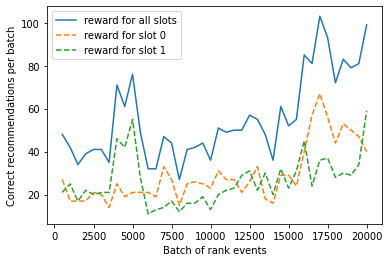

In [148]:
createChart(count, total_rewards, total_slot_rewards)

## Reading the chart

This chart shows the success of the model for the current default learning policy. 

The ideal target that by the end of the test, the loop is averaging a success rate that is close to one hundred percent minus the exploration. The default setting of exploration is 20%. 

`100-20=80`

This exploration setting is found in the Azure portal, for the Personalizer resource, in the Configurations tab, under the RESOURCE MANAGEMENT section 

In order to find a better learning policy, based on your data to the Rank API, run an [offline evaluation](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/how-to-offline-evaluation) in the portal for your Personalizer loop.

## Run an offline evaluation

1. In the Azure portal, open the Personalizer resource's **Evaluations** page.
1. Select **Create Evaluation**.
1. Enter the required data of evaluation name, and date range for the loop evaluation. The date range should include only the days you are focusing on for your evaluation. 

    The purpose of running this offline evaluation is to determine if there is a better learning policy for the features and actions used in this loop. To find that better learning policy, make sure **Optimization policy** is turned on.

1. Select **OK** to begin the evaluation. 
1. This **Evaluations** page lists the new evaluation and its current status. Depending on how much data you have, this evaluation can take some time. You can come back to this page after a few minutes to see the results. 
1. When the evaluation is completed, select the evaluation then select **Comparison of different learning policies**. This shows the available learning policies and how they would behave with the data. 
1. Select the top-most learning policy in the table and select **Apply**. This applies the _best_ learning policy to your model and retrains. 

## Validate new learning policy by running experiment for 5,000 iterations

Return to the Azure notebook, and continue by running the same loop but for only 5,000 iterations. Refresh the metrics chart in the Azure portal periodically to see the total calls to the service. When you have around 10,000 calls, a rank and reward call for each iteration of the loop, the iterations are done. 

In [149]:
# max iterations
num_requests = 5000

# check last mod date N% of time - currently 10%
lastModCheck2 = int(num_requests * .10)

jsonTemplate2 = rankactionsjsonobj

# main iterations
[count2, total_rewards2, total_slot_rewards2] = iterations(num_requests, lastModCheck2, jsonTemplate2, 500)

2021-03-28 22:44:34.711572
   1 None Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:34.717571
   1 None Bob 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:44:34.733574
   2 None Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:34.739573
   2 None Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:34.751573
   3 None Cathy 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:34.756572
   3 None Cathy 30 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:44:34.770573
   4 None Bob 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:34.776572
   4 None Bob 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:44:34.788573
   5 None Alice 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:34.793572
   5 None Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:44:34.805572
   6 

2021-03-28 22:44:35.459574
   43 None Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:44:35.465573
   43 None Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:35.477574
   44 None Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:35.483574
   44 None Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:35.497575
   45 None Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:35.501573
   45 None Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:35.515574
   46 None Alice 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:35.520573
   46 None Alice 7 Evening Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:44:35.535573
   47 None Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:35.542573
   47 None Cathy 30 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28

2021-03-28 22:44:36.400575
   93 None Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:36.405575
   93 None Alice 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:36.418575
   94 None Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:36.424576
   94 None Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:36.435574
   95 None Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:36.440576
   95 None Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:36.452575
   96 None Cathy 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:36.457575
   96 None Cathy 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:44:36.468574
   97 None Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:36.473575
   97 None Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-

2021-03-28 22:44:37.146577
   136 None Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:37.152578
   136 None Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:44:37.166577
   137 None Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:44:37.171576
   137 None Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:37.183576
   138 None Bob 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:37.188577
   138 None Bob 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:44:37.200576
   139 None Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:37.205577
   139 None Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:37.217577
   140 None Alice 7 Morning Desktop BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:44:37.221576
   140 None Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
2021-03-28 

2021-03-28 22:44:37.900578
   179 None Bob 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:37.906578
   179 None Bob 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:44:37.921578
   180 None Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:37.926578
   180 None Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:37.939580
   181 None Cathy 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:37.945578
   181 None Cathy 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:37.958579
   182 None Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:37.963578
   182 None Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:37.977579
   183 None Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:37.983579
   183 None Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44

2021-03-28 22:44:38.835582
   230 None Cathy 30 Morning Mobile BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:44:38.840583
   230 None Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:44:38.852580
   231 None Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:38.858581
   231 None Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:44:38.872581
   232 None Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:38.877580
   232 None Alice 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:44:38.889581
   233 None Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:38.895582
   233 None Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:38.909583
   234 None Cathy 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:38.916581
   234 None Cathy 30 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
2021-

2021-03-28 22:44:39.583582
   273 None Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:39.588582
   273 None Alice 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:44:39.601583
   274 None Cathy 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:39.606583
   274 None Cathy 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:39.618583
   275 None Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:39.622582
   275 None Alice 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:44:39.634583
   276 None Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:44:39.639583
   276 None Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:39.650582
   277 None Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:39.655583
   277 None Cathy 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:

2021-03-28 22:44:40.335583
   316 None Cathy 30 Afternoon Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:44:40.340584
   316 None Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:40.353588
   317 None Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:40.358583
   317 None Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:40.370584
   318 None Alice 7 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:44:40.374584
   318 None Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:44:40.387583
   319 None Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:40.391584
   319 None Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:44:40.403584
   320 None Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:40.408584
   320 None Alice 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-

2021-03-28 22:44:41.080585
   358 None Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:41.085585
   358 None Alice 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:41.099585
   359 None Cathy 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:41.104585
   359 None Cathy 7 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:44:41.116586
   360 None Bob 7 Evening Mobile BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:44:41.121586
   360 None Bob 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:44:41.134587
   361 None Bob 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:41.139585
   361 None Bob 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:44:41.152586
   362 None Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:41.157585
   362 None Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:4

2021-03-28 22:44:41.837587
   402 None Bob 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:41.842589
   402 None Bob 21 Morning Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:44:41.855587
   403 None Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:41.860587
   403 None Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:41.872588
   404 None Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:41.877587
   404 None Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:41.890586
   405 None Alice 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:41.896588
   405 None Alice 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:44:41.908587
   406 None Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:41.913586
   406 None Bob 21 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:44:41

2021-03-28 22:44:42.586589
   445 None Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:42.594590
   445 None Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:44:42.609589
   446 None Bob 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:44:42.615589
   446 None Bob 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:44:42.629587
   447 None Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:44:42.635589
   447 None Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:44:42.651590
   448 None Cathy 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:42.658589
   448 None Cathy 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:42.671588
   449 None Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:42.677588
   449 None Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:4

2021-03-28 22:44:43.520589
   495 None Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:44:43.526589
   495 None Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:43.541591
   496 None Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:43.547590
   496 None Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:43.560591
   497 None Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:43.565590
   497 None Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:44:43.577593
   498 None Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:43.582591
   498 None Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
2021-03-28 22:44:43.594592
   499 None Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:44:43.600589
   499 None Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 2

2021-03-28 22:45:14.492301
   545 None Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:14.498301
   545 None Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:14.514301
   546 None Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:14.521303
   546 None Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:45:14.534301
   547 None Alice 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:14.540301
   547 None Alice 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:14.554300
   548 None Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:14.559301
   548 None Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:45:14.571302
   549 None Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:14.576301
   549 None Alice 21 Evening Mobile SmallSidebar XBox-Series X-117 0 
2021-03-2

2021-03-28 22:45:15.430301
   597 None Alice 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:15.435301
   597 None Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:15.447303
   598 None Cathy 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:15.451301
   598 None Cathy 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:45:15.465303
   599 None Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:15.469304
   599 None Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:45:15.481303
   600 None Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:15.486302
   600 None Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:15.498303
   601 None Bob 30 Morning Desktop BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:45:15.503305
   601 None Bob 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 

2021-03-28 22:45:16.181304
   639 None Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:16.185304
   639 None Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:45:16.198303
   640 None Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:16.204305
   640 None Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:16.216304
   641 None Alice 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:16.221305
   641 None Alice 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:16.232303
   642 None Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:16.237305
   642 None Bob 21 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:45:16.249303
   643 None Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:16.254304
   643 None Alice 7 Afternoon Desktop SmallSidebar XBox-Series X-117 0 


2021-03-28 22:45:16.932274
   682 None Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:16.938274
   682 None Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:45:16.950274
   683 None Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:16.955274
   683 None Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:16.966273
   684 None Cathy 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:16.971275
   684 None Cathy 21 Morning Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:16.982274
   685 None Bob 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:16.987274
   685 None Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:17.000273
   686 None Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:45:17.006274
   686 None Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:

2021-03-28 22:45:17.867275
   733 None Bob 7 Evening Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:45:17.872276
   733 None Bob 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:17.884276
   734 None Cathy 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:17.889275
   734 None Cathy 7 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:17.902275
   735 None Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:17.907276
   735 None Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:17.920275
   736 None Cathy 21 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:17.926276
   736 None Cathy 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:17.940277
   737 None Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:17.945276
   737 None Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-

2021-03-28 22:45:18.620277
   776 None Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:18.626278
   776 None Bob 30 Evening Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:18.638278
   777 None Cathy 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:18.643277
   777 None Cathy 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:45:18.656279
   778 None Cathy 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:18.663277
   778 None Cathy 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:45:18.677277
   779 None Cathy 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:18.682278
   779 None Cathy 7 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:18.695278
   780 None Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:18.702276
   780 None Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021

2021-03-28 22:45:19.548281
   826 None Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:19.563279
   827 None Cathy 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:19.569278
   827 None Cathy 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:19.581279
   828 None Alice 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:19.586278
   828 None Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:45:19.597279
   829 None Bob 7 Afternoon Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:45:19.602278
   829 None Bob 7 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:19.613279
   830 None Alice 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:19.618280
   830 None Alice 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:19.631280
   831 None Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-2

2021-03-28 22:45:20.302279
   869 None Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:20.308283
   869 None Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:20.320281
   870 None Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:20.326282
   870 None Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:20.339280
   871 None Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:20.345281
   871 None Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:45:20.356280
   872 None Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:20.361280
   872 None Alice 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:45:20.373280
   873 None Alice 30 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:45:20.378281
   873 None Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45

2021-03-28 22:45:21.049283
   912 None Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:21.054284
   912 None Alice 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:21.066284
   913 None Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:21.071285
   913 None Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:21.082283
   914 None Cathy 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:21.087283
   914 None Cathy 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:45:21.099284
   915 None Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:21.103285
   915 None Alice 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:21.114282
   916 None Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:21.119282
   916 None Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 

2021-03-28 22:45:21.800284
   956 None Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:21.812284
   957 None Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:21.817286
   957 None Bob 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:21.830284
   958 None Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:21.834284
   958 None Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:21.846284
   959 None Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:21.851283
   959 None Alice 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:21.863285
   960 None Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:21.867284
   960 None Alice 30 Morning Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:45:21.880284
   961 None Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22

2021-03-28 22:45:22.549285
   1000 None Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:22.554285
   1000 None Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
**** 10% of loop found
-----checking model
<Response [200]>
{'creationTime': '2021-03-11T06:09:18+00:00', 'lastModifiedTime': '2021-03-29T05:45:15+00:00'}
-----model updated: "2021-03-29T05:45:15+00:00"
**** aggregating rewards
2021-03-28 22:45:52.693458
   1001 None Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:52.698457
   1001 None Alice 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:52.710457
   1002 None Alice 30 Afternoon Desktop BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:45:52.715460
   1002 None Alice 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:52.731457
   1003 None Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:52.736457
   1003 None Bob 30 Afternoon Mobile

   1044 None Cathy 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:53.450461
   1045 None Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:53.457459
   1045 None Bob 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:53.469459
   1046 None Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:53.474458
   1046 None Bob 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:53.486461
   1047 None Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:53.491459
   1047 None Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:53.504458
   1048 None Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:53.509460
   1048 None Alice 7 Evening Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:53.520460
   1049 None Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:53.525459
   1049 None C

2021-03-28 22:45:54.190460
   1088 None Alice 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:54.202463
   1089 None Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:54.208462
   1089 None Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:54.221460
   1090 None Cathy 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:54.226460
   1090 None Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:54.246461
   1091 None Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:54.251460
   1091 None Cathy 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:54.265460
   1092 None Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:54.270460
   1092 None Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:45:54.282460
   1093 None Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0

2021-03-28 22:45:54.939462
   1130 None Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:54.952462
   1131 None Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:54.959462
   1131 None Alice 21 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:45:54.973462
   1132 None Alice 30 Afternoon Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:45:54.978462
   1132 None Alice 30 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:54.991462
   1133 None Cathy 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:54.996462
   1133 None Cathy 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:55.008462
   1134 None Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:55.013463
   1134 None Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:55.024462
   1135 None Alice 30 Evening Desktop BigHeroPosition Red-Polo-Shi

2021-03-28 22:45:55.694464
   1172 None Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:45:55.699463
   1172 None Cathy 21 Morning Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:55.712464
   1173 None Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:55.718463
   1173 None Alice 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:55.730462
   1174 None Alice 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:55.736463
   1174 None Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:55.748463
   1175 None Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:55.753464
   1175 None Cathy 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:55.766463
   1176 None Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:55.771464
   1176 None Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 

2021-03-28 22:45:56.441464
   1214 None Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:56.446466
   1214 None Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:45:56.461467
   1215 None Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:56.467465
   1215 None Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:56.481465
   1216 None Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:56.487467
   1216 None Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:56.503465
   1217 None Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:45:56.508466
   1217 None Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:56.522466
   1218 None Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:56.527466
   1218 None Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
2

2021-03-28 22:45:57.379468
   1264 None Alice 30 Morning Desktop BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:45:57.386467
   1264 None Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:57.400466
   1265 None Cathy 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:57.405468
   1265 None Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:57.417467
   1266 None Cathy 21 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:57.422469
   1266 None Cathy 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:57.434466
   1267 None Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:57.439468
   1267 None Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:57.450466
   1268 None Cathy 7 Morning Mobile BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:45:57.455467
   1268 None Cathy 7 Morning Mobile SmallSidebar Tennis-Rack

2021-03-28 22:45:58.315468
   1315 None Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:58.321470
   1315 None Bob 21 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:58.335470
   1316 None Alice 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:58.340469
   1316 None Alice 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:45:58.355470
   1317 None Alice 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:58.360469
   1317 None Alice 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:45:58.373471
   1318 None Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:58.378471
   1318 None Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:58.391470
   1319 None Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:45:58.396468
   1319 None Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03

2021-03-28 22:45:59.254472
   1366 None Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:45:59.260471
   1366 None Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:45:59.273471
   1367 None Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:59.278471
   1367 None Bob 30 Evening Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:59.291471
   1368 None Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:45:59.295470
   1368 None Alice 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:45:59.308471
   1369 None Bob 21 Afternoon Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:45:59.313470
   1369 None Bob 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:45:59.326471
   1370 None Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:45:59.330471
   1370 None Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racke

   1407 None Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:00.008474
   1407 None Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:46:00.023474
   1408 None Bob 21 Afternoon Mobile BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:46:00.029472
   1408 None Bob 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:00.043472
   1409 None Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:00.049473
   1409 None Bob 7 Evening Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:46:00.062474
   1410 None Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:00.068475
   1410 None Cathy 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:46:00.081472
   1411 None Cathy 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:00.086472
   1411 None Cathy 7 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:46:00.100472

2021-03-28 22:46:00.939475
   1457 None Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:46:00.954475
   1458 None Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:00.962474
   1458 None Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:00.977476
   1459 None Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:00.983477
   1459 None Bob 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:46:00.997474
   1460 None Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:01.002474
   1460 None Alice 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:01.014474
   1461 None Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:46:01.019473
   1461 None Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:46:01.032475
   1462 None Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 

<Response [200]>
{'creationTime': '2021-03-11T06:09:18+00:00', 'lastModifiedTime': '2021-03-29T05:45:45+00:00'}
-----model updated: "2021-03-29T05:45:45+00:00"
**** aggregating rewards
2021-03-28 22:46:32.026014
   1501 None Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:32.031014
   1501 None Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:32.050013
   1502 None Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:46:32.055013
   1502 None Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:32.069013
   1503 None Cathy 21 Morning Desktop BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:46:32.074012
   1503 None Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:32.087014
   1504 None Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:32.092013
   1504 None Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-

2021-03-28 22:46:32.772017
   1544 None Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:32.777014
   1544 None Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:46:32.790016
   1545 None Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:32.795015
   1545 None Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:32.808015
   1546 None Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:32.813013
   1546 None Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:46:32.825014
   1547 None Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:32.830015
   1547 None Alice 30 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:46:32.842018
   1548 None Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:32.847014
   1548 None Cathy 21 Evening Mobile SmallSidebar XBox-Series X-1

2021-03-28 22:46:33.518017
   1587 None Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:33.523017
   1587 None Alice 30 Morning Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:46:33.537017
   1588 None Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:33.542017
   1588 None Bob 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:46:33.555017
   1589 None Alice 7 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:46:33.559015
   1589 None Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:46:33.572016
   1590 None Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:33.578016
   1590 None Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:33.590016
   1591 None Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:33.594016
   1591 None Bob 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
202

2021-03-28 22:46:34.273017
   1630 None Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:34.280017
   1630 None Alice 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:46:34.292017
   1631 None Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:34.298017
   1631 None Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:34.310017
   1632 None Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:34.315018
   1632 None Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:34.329018
   1633 None Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:34.335018
   1633 None Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:46:34.346018
   1634 None Alice 21 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:46:34.352019
   1634 None Alice 21 Afternoon Mobile SmallSidebar Tennis-Racket-133

2021-03-28 22:46:35.018020
   1673 None Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:35.024020
   1673 None Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:46:35.037019
   1674 None Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:35.042019
   1674 None Bob 7 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:46:35.055019
   1675 None Cathy 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:35.060019
   1675 None Cathy 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:35.072020
   1676 None Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:35.077021
   1676 None Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:46:35.090019
   1677 None Alice 21 Morning Mobile BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:46:35.095019
   1677 None Alice 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
20

2021-03-28 22:46:35.766022
   1716 None Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:35.773022
   1716 None Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:46:35.785021
   1717 None Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:35.790021
   1717 None Alice 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:35.802022
   1718 None Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:35.807021
   1718 None Bob 21 Morning Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:46:35.819024
   1719 None Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:35.824022
   1719 None Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:46:35.835020
   1720 None Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:35.840022
   1720 None Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-2

2021-03-28 22:46:36.519025
   1760 None Bob 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:36.532023
   1761 None Bob 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:36.538023
   1761 None Bob 7 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:46:36.550023
   1762 None Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:36.555022
   1762 None Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:46:36.567022
   1763 None Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:36.573023
   1763 None Bob 30 Morning Mobile SmallSidebar XBox-Series X-117 1 
2021-03-28 22:46:36.586024
   1764 None Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:36.591024
   1764 None Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:36.603024
   1765 None Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
2021-03-28 2

2021-03-28 22:46:37.271023
   1804 None Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:37.276024
   1804 None Bob 21 Evening Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:46:37.289025
   1805 None Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:46:37.294024
   1805 None Cathy 21 Morning Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:46:37.306024
   1806 None Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:37.311026
   1806 None Alice 30 Morning Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:46:37.323025
   1807 None Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:37.328025
   1807 None Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:37.340024
   1808 None Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:37.345025
   1808 None Bob 7 Evening Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 2

2021-03-28 22:46:38.018026
   1846 None Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:38.024026
   1846 None Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:38.038027
   1847 None Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:38.043028
   1847 None Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:46:38.055027
   1848 None Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:38.060025
   1848 None Cathy 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:46:38.071027
   1849 None Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:38.076028
   1849 None Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:46:38.088026
   1850 None Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:38.092026
   1850 None Bob 21 Morning Desktop SmallSidebar XBox-Series X-11

2021-03-28 22:46:38.773027
   1889 None Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:38.778028
   1889 None Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:38.790027
   1890 None Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:38.795028
   1890 None Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:46:38.807027
   1891 None Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:38.812028
   1891 None Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:46:38.823027
   1892 None Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:38.829027
   1892 None Alice 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:46:38.840026
   1893 None Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:38.844027
   1893 None Alice 30 Morning Desktop SmallSidebar 31-Inch-Mo

2021-03-28 22:46:39.516029
   1931 None Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:46:39.522030
   1931 None Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:46:39.535032
   1932 None Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:39.540029
   1932 None Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
2021-03-28 22:46:39.552030
   1933 None Bob 7 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:46:39.557028
   1933 None Bob 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:39.568029
   1934 None Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:46:39.574030
   1934 None Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:39.587030
   1935 None Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:46:39.592028
   1935 None Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 

2021-03-28 22:46:40.268031
   1975 None Cathy 21 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:46:40.281034
   1976 None Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:46:40.286030
   1976 None Alice 7 Evening Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:46:40.300029
   1977 None Bob 21 Evening Desktop BigHeroPosition 31-Inch-Monitor-771 1 
2021-03-28 22:46:40.304031
   1977 None Bob 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:40.317031
   1978 None Cathy 21 Afternoon Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:46:40.322032
   1978 None Cathy 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:46:40.336033
   1979 None Cathy 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:46:40.341030
   1979 None Cathy 7 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:46:40.352031
   1980 None Cathy 21 Morning Desktop BigHeroPosition Red-Pol

2021-03-28 22:47:11.203532
   2023 None Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:11.216532
   2024 None Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:11.221533
   2024 None Cathy 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:11.233532
   2025 None Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:11.238533
   2025 None Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:11.250531
   2026 None Alice 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:11.254532
   2026 None Alice 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:11.265532
   2027 None Cathy 21 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:11.270533
   2027 None Cathy 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:11.282533
   2028 None Cathy 30 Afternoon Mobile BigHeroPosition Red-Polo-

2021-03-28 22:47:11.957535
   2068 None Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:11.969534
   2069 None Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:47:11.974534
   2069 None Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:11.987534
   2070 None Cathy 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:11.991533
   2070 None Cathy 30 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:12.003534
   2071 None Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:47:12.007535
   2071 None Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:12.019535
   2072 None Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:12.023534
   2072 None Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:12.035534
   2073 None Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2

2021-03-28 22:47:12.710538
   2114 None Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:12.716536
   2114 None Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:12.728534
   2115 None Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:12.734536
   2115 None Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:12.748536
   2116 None Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:12.753536
   2116 None Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:12.765536
   2117 None Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:12.770534
   2117 None Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:12.781535
   2118 None Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:47:12.786535
   2118 None Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021

2021-03-28 22:47:13.460538
   2158 None Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:13.465537
   2158 None Bob 30 Morning Mobile SmallSidebar XBox-Series X-117 1 
2021-03-28 22:47:13.477537
   2159 None Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:13.482538
   2159 None Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:13.494539
   2160 None Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:13.499536
   2160 None Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:13.510536
   2161 None Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:13.515537
   2161 None Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:13.525539
   2162 None Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:13.530537
   2162 None Bob 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:1

2021-03-28 22:47:14.205539
   2203 None Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:14.220540
   2204 None Bob 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:14.225539
   2204 None Bob 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:47:14.238540
   2205 None Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:14.243538
   2205 None Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:14.256539
   2206 None Alice 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:14.261539
   2206 None Alice 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:14.274542
   2207 None Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:14.279539
   2207 None Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:14.292539
   2208 None Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 

2021-03-28 22:47:14.956541
   2247 None Cathy 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:14.962541
   2247 None Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:14.974541
   2248 None Alice 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:14.979539
   2248 None Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:14.991543
   2249 None Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:14.995541
   2249 None Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:15.007539
   2250 None Cathy 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:15.012541
   2250 None Cathy 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:47:15.024541
   2251 None Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:15.029539
   2251 None Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-

2021-03-28 22:47:15.703541
   2290 None Alice 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 1 
2021-03-28 22:47:15.717544
   2291 None Bob 21 Afternoon Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:47:15.722542
   2291 None Bob 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:15.735543
   2292 None Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:15.740544
   2292 None Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:15.752542
   2293 None Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:15.757544
   2293 None Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:15.769542
   2294 None Cathy 7 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:47:15.774542
   2294 None Cathy 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:47:15.785542
   2295 None Alice 7 Evening Desktop BigHeroPosition Red-Polo-Shirt

2021-03-28 22:47:16.453544
   2335 None Alice 7 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:47:16.466544
   2336 None Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:16.472543
   2336 None Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:16.483543
   2337 None Cathy 30 Morning Mobile BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:47:16.488544
   2337 None Cathy 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:16.500545
   2338 None Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:16.504544
   2338 None Bob 30 Evening Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:16.516544
   2339 None Alice 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:16.520545
   2339 None Alice 30 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:47:16.533544
   2340 None Cathy 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 

2021-03-28 22:47:17.203545
   2378 None Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:17.214544
   2378 None Cathy 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:17.230545
   2379 None Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:17.237545
   2379 None Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:17.255546
   2380 None Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:17.261545
   2380 None Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:17.273544
   2381 None Alice 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:17.280544
   2381 None Alice 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:17.292544
   2382 None Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:17.297544
   2382 None Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-0

2021-03-28 22:47:17.956547
   2421 None Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:17.961546
   2421 None Bob 21 Evening Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:17.974547
   2422 None Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:17.979546
   2422 None Alice 30 Morning Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:47:17.991547
   2423 None Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:17.995547
   2423 None Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:18.007546
   2424 None Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:18.011545
   2424 None Alice 21 Morning Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:18.022547
   2425 None Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:47:18.027545
   2425 None Cathy 7 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 

2021-03-28 22:47:18.710548
   2465 None Cathy 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:18.715547
   2465 None Cathy 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:47:18.728550
   2466 None Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:18.733549
   2466 None Alice 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:18.747549
   2467 None Alice 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:18.752548
   2467 None Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:47:18.765549
   2468 None Bob 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:18.770549
   2468 None Bob 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:18.785549
   2469 None Alice 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:18.790549
   2469 None Alice 30 Evening Desktop SmallSidebar Tennis-Racket-

   2512 None Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:49.704543
   2513 None Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:49.711542
   2513 None Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:49.723542
   2514 None Cathy 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:49.728543
   2514 None Cathy 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:49.738542
   2515 None Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:49.743542
   2515 None Alice 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:49.755543
   2516 None Alice 7 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:47:49.760542
   2516 None Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:49.771541
   2517 None Cathy 21 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:4

2021-03-28 22:47:50.638545
   2558 None Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:50.647544
   2558 None Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:47:50.662546
   2559 None Cathy 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:50.669544
   2559 None Cathy 7 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:50.686544
   2560 None Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:50.693544
   2560 None Cathy 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:47:50.711546
   2561 None Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:50.718544
   2561 None Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:50.734546
   2562 None Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:50.741544
   2562 None Alice 21 Morning Mobile SmallSidebar Tennis-Racket-1

2021-03-28 22:47:51.564544
   2604 None Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:51.577545
   2605 None Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:51.584547
   2605 None Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:51.596548
   2606 None Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:51.601547
   2606 None Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:51.614546
   2607 None Alice 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:51.619547
   2607 None Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:51.631546
   2608 None Cathy 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:51.637545
   2608 None Cathy 7 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:51.649547
   2609 None Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-

2021-03-28 22:47:52.316548
   2646 None Bob 7 Evening Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:47:52.321548
   2646 None Bob 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:52.333548
   2647 None Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:52.338548
   2647 None Bob 30 Evening Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:52.350547
   2648 None Bob 7 Evening Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:47:52.355548
   2648 None Bob 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:52.366547
   2649 None Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:47:52.371548
   2649 None Bob 21 Morning Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:52.384548
   2650 None Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:52.388548
   2650 None Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:

2021-03-28 22:47:53.071550
   2691 None Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:53.076548
   2691 None Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:53.088550
   2692 None Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:53.093549
   2692 None Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
2021-03-28 22:47:53.105549
   2693 None Bob 21 Afternoon Desktop BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:47:53.110548
   2693 None Bob 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:53.122549
   2694 None Alice 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:53.127550
   2694 None Alice 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:53.139549
   2695 None Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:53.145549
   2695 None Bob 30 Morning Mobile SmallSidebar XBox-Series X-117 1 
202

2021-03-28 22:47:53.819551
   2735 None Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:47:53.823550
   2735 None Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:53.836551
   2736 None Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:53.841551
   2736 None Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:53.853553
   2737 None Alice 30 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:47:53.858551
   2737 None Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:53.871550
   2738 None Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:53.875551
   2738 None Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:53.888550
   2739 None Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:53.893551
   2739 None Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 

2021-03-28 22:47:54.566553
   2779 None Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:54.571552
   2779 None Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:54.583552
   2780 None Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:54.588554
   2780 None Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:54.600553
   2781 None Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:54.604554
   2781 None Alice 30 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:47:54.616553
   2782 None Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:47:54.620552
   2782 None Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:54.632552
   2783 None Cathy 30 Evening Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:47:54.636552
   2783 None Cathy 30 Evening Desktop SmallSidebar Tenni

2021-03-28 22:47:55.319553
   2824 None Cathy 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:55.325554
   2824 None Cathy 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:47:55.337554
   2825 None Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:55.342553
   2825 None Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:55.353554
   2826 None Alice 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:55.358554
   2826 None Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:47:55.370553
   2827 None Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:55.374553
   2827 None Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:55.387554
   2828 None Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:55.392556
   2828 None Alice 21 Evening Mobile SmallSidebar Tennis-Rack

   2868 None Alice 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:56.068556
   2868 None Alice 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:47:56.082555
   2869 None Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:56.087555
   2869 None Bob 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:56.098555
   2870 None Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:56.103555
   2870 None Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:56.115555
   2871 None Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:56.120558
   2871 None Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:56.132556
   2872 None Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:56.137555
   2872 None Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:56.15055

2021-03-28 22:47:56.813557
   2913 None Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:56.820557
   2913 None Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:56.832558
   2914 None Alice 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:56.837557
   2914 None Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:56.848556
   2915 None Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:47:56.853558
   2915 None Bob 21 Morning Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:56.867556
   2916 None Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:56.872556
   2916 None Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:47:56.884557
   2917 None Alice 7 Morning Mobile BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:47:56.889557
   2917 None Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021

2021-03-28 22:47:57.564558
   2958 None Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:47:57.569559
   2958 None Cathy 21 Morning Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:57.581559
   2959 None Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:47:57.587562
   2959 None Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:47:57.599559
   2960 None Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:57.604558
   2960 None Bob 21 Evening Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:57.615557
   2961 None Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:57.620558
   2961 None Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:47:57.631559
   2962 None Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:47:57.635559
   2962 None Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021

<Response [200]>
{'creationTime': '2021-03-11T06:09:18+00:00', 'lastModifiedTime': '2021-03-29T05:47:45+00:00'}
-----model updated: "2021-03-29T05:47:45+00:00"
**** aggregating rewards
2021-03-28 22:48:28.406852
   3001 None Bob 30 Afternoon Mobile BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:48:28.412855
   3001 None Bob 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:48:28.432853
   3002 None Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:28.437853
   3002 None Cathy 21 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:48:28.457854
   3003 None Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:28.463855
   3003 None Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:28.478854
   3004 None Alice 7 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:48:28.483852
   3004 None Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-2

2021-03-28 22:48:29.156984
   3042 None Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:29.170489
   3043 None Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:29.176489
   3043 None Alice 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:29.188489
   3044 None Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:29.193492
   3044 None Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:29.204490
   3045 None Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:29.210493
   3045 None Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:29.222491
   3046 None Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:29.226489
   3046 None Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:29.237488
   3047 None Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 

2021-03-28 22:48:29.907491
   3087 None Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:29.913491
   3087 None Alice 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:29.925492
   3088 None Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:29.930490
   3088 None Alice 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:29.942491
   3089 None Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:29.947491
   3089 None Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:48:29.960492
   3090 None Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:29.964494
   3090 None Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:29.976491
   3091 None Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:29.981491
   3091 None Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0

2021-03-28 22:48:30.662493
   3131 None Alice 21 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:48:30.679496
   3132 None Bob 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:30.686493
   3132 None Bob 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:30.699494
   3133 None Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:30.704493
   3133 None Bob 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:48:30.717494
   3134 None Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:30.722494
   3134 None Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:48:30.734492
   3135 None Bob 21 Afternoon Desktop BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:48:30.739492
   3135 None Bob 21 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:48:30.752493
   3136 None Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2

2021-03-28 22:48:31.598494
   3182 None Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:48:31.613496
   3183 None Alice 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:31.620495
   3183 None Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:48:31.633494
   3184 None Alice 7 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:48:31.639495
   3184 None Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:48:31.651496
   3185 None Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:31.656495
   3185 None Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
2021-03-28 22:48:31.670495
   3186 None Cathy 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:31.675494
   3186 None Cathy 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:31.689496
   3187 None Bob 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-43

2021-03-28 22:48:32.535498
   3231 None Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:32.542498
   3231 None Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:48:32.557497
   3232 None Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:32.563496
   3232 None Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:48:32.578498
   3233 None Cathy 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:32.583496
   3233 None Cathy 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:48:32.599496
   3234 None Bob 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:32.606496
   3234 None Bob 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:32.622498
   3235 None Bob 30 Evening Mobile BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:48:32.627497
   3235 None Bob 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 


2021-03-28 22:48:33.470499
   3279 None Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:33.478499
   3279 None Cathy 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:33.491498
   3280 None Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:33.498499
   3280 None Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:33.511499
   3281 None Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:33.516498
   3281 None Alice 7 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:48:33.528498
   3282 None Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:33.533498
   3282 None Alice 21 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:48:33.545499
   3283 None Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:33.549498
   3283 None Alice 21 Morning Mobile SmallSidebar Tennis-Racke

2021-03-28 22:48:34.220525
   3320 None Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:48:34.233525
   3321 None Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:34.238525
   3321 None Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:48:34.250525
   3322 None Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:34.255525
   3322 None Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:34.266525
   3323 None Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:34.271528
   3323 None Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:48:34.282525
   3324 None Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:34.287525
   3324 None Bob 30 Morning Mobile SmallSidebar XBox-Series X-117 1 
2021-03-28 22:48:34.298526
   3325 None Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-0

2021-03-28 22:48:34.973529
   3362 None Alice 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:48:34.986528
   3363 None Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:34.992528
   3363 None Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:35.004527
   3364 None Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:35.009528
   3364 None Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:35.023528
   3365 None Alice 7 Evening Desktop BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:48:35.028527
   3365 None Alice 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:35.041526
   3366 None Cathy 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:35.047528
   3366 None Cathy 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:35.060528
   3367 None Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
20

2021-03-28 22:48:35.726529
   3404 None Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:35.732528
   3404 None Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:48:35.745529
   3405 None Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:35.751531
   3405 None Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:48:35.764530
   3406 None Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:48:35.769529
   3406 None Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:35.782529
   3407 None Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:35.787530
   3407 None Bob 7 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:48:35.800530
   3408 None Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:35.805528
   3408 None Cathy 7 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-

2021-03-28 22:48:36.473529
   3447 None Cathy 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:36.479534
   3447 None Cathy 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:48:36.491533
   3448 None Bob 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:36.496530
   3448 None Bob 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:36.507531
   3449 None Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:48:36.512533
   3449 None Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:48:36.523532
   3450 None Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:48:36.528529
   3450 None Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:36.539531
   3451 None Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:36.543533
   3451 None Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-

2021-03-28 22:48:37.221533
   3492 None Cathy 7 Afternoon Desktop BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:48:37.226532
   3492 None Cathy 7 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:37.238532
   3493 None Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:37.242532
   3493 None Alice 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:48:37.255533
   3494 None Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:37.260531
   3494 None Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:37.272532
   3495 None Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:48:37.278532
   3495 None Alice 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:48:37.291535
   3496 None Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:48:37.296532
   3496 None Alice 30 Evening Desktop SmallSidebar Red-Polo-Shir

2021-03-28 22:49:08.254778
   3542 None Bob 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:08.259781
   3542 None Bob 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:08.271778
   3543 None Alice 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:08.276777
   3543 None Alice 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:08.289778
   3544 None Bob 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:08.295778
   3544 None Bob 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:08.309779
   3545 None Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:08.314779
   3545 None Alice 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:08.326778
   3546 None Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:08.330778
   3546 None Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-0

2021-03-28 22:49:09.010780
   3585 None Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:09.016780
   3585 None Bob 7 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:49:09.028782
   3586 None Cathy 7 Evening Mobile BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:49:09.034779
   3586 None Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:09.048779
   3587 None Alice 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:09.053779
   3587 None Alice 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:09.064780
   3588 None Alice 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:09.068781
   3588 None Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:09.079780
   3589 None Bob 30 Evening Desktop BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:49:09.084782
   3589 None Bob 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 

2021-03-28 22:49:09.761782
   3629 None Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:09.767781
   3629 None Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:09.783782
   3630 None Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:09.789783
   3630 None Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:09.804780
   3631 None Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:09.810782
   3631 None Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:49:09.821783
   3632 None Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:09.827781
   3632 None Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:09.841784
   3633 None Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:09.848781
   3633 None Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 


2021-03-28 22:49:10.688784
   3679 None Cathy 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:10.694784
   3679 None Cathy 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:10.707783
   3680 None Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:10.712783
   3680 None Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:49:10.726783
   3681 None Cathy 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:10.732785
   3681 None Cathy 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:49:10.746783
   3682 None Cathy 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:10.753783
   3682 None Cathy 7 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:10.766784
   3683 None Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:10.770783
   3683 None Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt

2021-03-28 22:49:11.625786
   3724 None Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:49:11.632787
   3724 None Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:11.644785
   3725 None Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:11.650785
   3725 None Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:49:11.661784
   3726 None Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:11.666786
   3726 None Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:49:11.678786
   3727 None Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:11.683785
   3727 None Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:49:11.695787
   3728 None Bob 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:11.699784
   3728 None Bob 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:

2021-03-28 22:49:12.563787
   3771 None Bob 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:12.584789
   3772 None Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:12.591787
   3772 None Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:12.607787
   3773 None Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:12.614787
   3773 None Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:49:12.629798
   3774 None Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:12.638789
   3774 None Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:12.655790
   3775 None Cathy 21 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:12.662788
   3775 None Cathy 21 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:49:12.679788
   3776 None Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-13

2021-03-28 22:49:13.500792
   3813 None Cathy 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:13.506791
   3813 None Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:13.520792
   3814 None Bob 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:13.525792
   3814 None Bob 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:13.538790
   3815 None Alice 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:13.543790
   3815 None Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:49:13.555791
   3816 None Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:13.561790
   3816 None Alice 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 1 
2021-03-28 22:49:13.574789
   3817 None Alice 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:13.580789
   3817 None Alice 7 Evening Desktop SmallSidebar 31-Inch-Monitor-

2021-03-28 22:49:14.441791
   3856 None Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:14.448792
   3856 None Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:14.462792
   3857 None Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:14.468792
   3857 None Alice 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:14.483792
   3858 None Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:49:14.489791
   3858 None Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:14.504791
   3859 None Alice 30 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:49:14.510793
   3859 None Alice 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:14.524793
   3860 None Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:14.530794
   3860 None Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-43

2021-03-28 22:49:15.392793
   3902 None Bob 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:15.398793
   3902 None Bob 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:49:15.412794
   3903 None Alice 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:15.418793
   3903 None Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:49:15.431794
   3904 None Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:15.436792
   3904 None Alice 21 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:49:15.449794
   3905 None Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:15.454795
   3905 None Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:15.467794
   3906 None Bob 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:15.472793
   3906 None Bob 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2

2021-03-28 22:49:16.329796
   3953 None Bob 30 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:49:16.335796
   3953 None Bob 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:49:16.347796
   3954 None Cathy 21 Morning Desktop BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:49:16.353794
   3954 None Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:16.364795
   3955 None Bob 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:16.369795
   3955 None Bob 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:16.382797
   3956 None Cathy 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:16.387796
   3956 None Cathy 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:16.400797
   3957 None Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:16.406796
   3957 None Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021

2021-03-28 22:49:17.082796
   3994 None Cathy 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:17.088798
   3994 None Cathy 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:49:17.103798
   3995 None Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:17.109797
   3995 None Alice 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:17.122796
   3996 None Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:17.126797
   3996 None Cathy 7 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:49:17.138796
   3997 None Alice 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:17.142796
   3997 None Alice 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:17.154796
   3998 None Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:17.159797
   3998 None Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shi

2021-03-28 22:49:47.883405
   4035 None Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:47.887404
   4035 None Cathy 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:47.900404
   4036 None Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:49:47.904405
   4036 None Alice 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:49:47.916403
   4037 None Bob 30 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:49:47.921404
   4037 None Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:49:47.933405
   4038 None Alice 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:47.938404
   4038 None Alice 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:49:47.949403
   4039 None Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:47.953403
   4039 None Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 

2021-03-28 22:49:48.630407
   4078 None Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:49:48.644408
   4079 None Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:49:48.649408
   4079 None Cathy 21 Morning Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:49:48.664408
   4080 None Bob 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:48.670406
   4080 None Bob 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:48.683407
   4081 None Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:48.688406
   4081 None Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:48.699407
   4082 None Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:48.704407
   4082 None Cathy 30 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:49:48.715406
   4083 None Alice 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0

2021-03-28 22:49:49.378409
   4124 None Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:49:49.383408
   4124 None Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:49:49.397411
   4125 None Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:49.404408
   4125 None Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:49.416411
   4126 None Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:49.421409
   4126 None Alice 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:49.432407
   4127 None Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:49.437407
   4127 None Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:49.451409
   4128 None Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:49.456408
   4128 None Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432

2021-03-28 22:49:50.134409
   4166 None Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:50.139408
   4166 None Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:49:50.149409
   4167 None Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:50.154408
   4167 None Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:50.166410
   4168 None Alice 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:50.171408
   4168 None Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:50.184408
   4169 None Alice 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:50.188411
   4169 None Alice 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:50.200409
   4170 None Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:50.204409
   4170 None Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
202

2021-03-28 22:49:51.076411
   4217 None Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:51.082412
   4217 None Bob 21 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:49:51.096413
   4218 None Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:51.101412
   4218 None Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:51.116412
   4219 None Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:51.122411
   4219 None Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:49:51.135415
   4220 None Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:49:51.140411
   4220 None Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:51.153412
   4221 None Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:51.158411
   4221 None Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-

2021-03-28 22:49:51.816412
   4259 None Bob 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:51.821412
   4259 None Bob 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:51.834412
   4260 None Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:51.839412
   4260 None Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:49:51.851413
   4261 None Cathy 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:51.856413
   4261 None Cathy 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:49:51.868413
   4262 None Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:51.872411
   4262 None Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:51.883412
   4263 None Bob 21 Evening Desktop BigHeroPosition XBox-Series X-117 0 
2021-03-28 22:49:51.887411
   4263 None Bob 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-

2021-03-28 22:49:52.566414
   4302 None Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:52.581416
   4303 None Bob 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:52.587414
   4303 None Bob 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:52.606415
   4304 None Cathy 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:52.622414
   4304 None Cathy 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:52.638416
   4305 None Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:49:52.645414
   4305 None Bob 21 Morning Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:49:52.659415
   4306 None Cathy 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:52.664415
   4306 None Cathy 30 Morning Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:49:52.678416
   4307 None Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
2021-0

2021-03-28 22:49:53.501416
   4354 None Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:49:53.515417
   4355 None Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:53.521416
   4355 None Bob 30 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:49:53.534417
   4356 None Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:53.539417
   4356 None Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:49:53.552417
   4357 None Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:49:53.559418
   4357 None Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:53.574417
   4358 None Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:49:53.580418
   4358 None Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:49:53.597419
   4359 None Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
202

   4402 None Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:49:54.454420
   4403 None Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:54.462419
   4403 None Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:54.476419
   4404 None Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:54.482419
   4404 None Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:54.496420
   4405 None Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:54.503423
   4405 None Alice 21 Morning Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:49:54.517421
   4406 None Alice 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:54.523417
   4406 None Alice 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:54.537420
   4407 None Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:54.54241

2021-03-28 22:49:55.379467
   4455 None Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:55.385469
   4455 None Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:55.398469
   4456 None Alice 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:55.403468
   4456 None Alice 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:55.415468
   4457 None Alice 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:55.419468
   4457 None Alice 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:55.430468
   4458 None Alice 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:49:55.435470
   4458 None Alice 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:49:55.445468
   4459 None Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:49:55.450469
   4459 None Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133

<Response [200]>
{'creationTime': '2021-03-11T06:09:18+00:00', 'lastModifiedTime': '2021-03-29T05:49:45+00:00'}
-----model updated: "2021-03-29T05:49:45+00:00"
**** aggregating rewards
2021-03-28 22:50:26.244778
   4501 None Alice 7 Evening Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:50:26.249777
   4501 None Alice 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:26.263779
   4502 None Alice 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:26.268781
   4502 None Alice 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:26.279777
   4503 None Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:26.283777
   4503 None Bob 21 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:50:26.304117
   4504 None Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:50:26.310117
   4504 None Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03

2021-03-28 22:50:26.992117
   4545 None Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:26.997117
   4545 None Cathy 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:27.010117
   4546 None Cathy 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:27.015117
   4546 None Cathy 7 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:27.027118
   4547 None Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:50:27.031118
   4547 None Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:27.042118
   4548 None Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:27.046118
   4548 None Bob 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:50:27.058118
   4549 None Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:27.063117
   4549 None Alice 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0

2021-03-28 22:50:27.754119
   4589 None Alice 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:27.759121
   4589 None Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:50:27.771120
   4590 None Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:27.775120
   4590 None Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:50:27.788120
   4591 None Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:27.792119
   4591 None Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:50:27.804119
   4592 None Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:27.809120
   4592 None Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:50:27.820120
   4593 None Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:27.825123
   4593 None Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03

2021-03-28 22:50:28.511120
   4634 None Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:28.517122
   4634 None Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:28.532121
   4635 None Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:28.539122
   4635 None Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:50:28.552121
   4636 None Alice 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:28.559121
   4636 None Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:28.573123
   4637 None Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:50:28.579122
   4637 None Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:50:28.591121
   4638 None Alice 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:28.596123
   4638 None Alice 7 Evening Desktop SmallSidebar Tennis-Racket-133

2021-03-28 22:50:29.251123
   4676 None Cathy 7 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
2021-03-28 22:50:29.264124
   4677 None Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:29.269124
   4677 None Alice 30 Morning Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:50:29.281123
   4678 None Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:29.285123
   4678 None Alice 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:29.297123
   4679 None Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:29.302123
   4679 None Alice 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:50:29.313123
   4680 None Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:29.317122
   4680 None Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:29.329123
   4681 None Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 

2021-03-28 22:50:30.011123
   4721 None Cathy 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:30.018126
   4721 None Cathy 7 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:30.032125
   4722 None Cathy 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:30.036124
   4722 None Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:30.051125
   4723 None Bob 21 Afternoon Mobile BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:50:30.056124
   4723 None Bob 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:30.069125
   4724 None Alice 30 Evening Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2021-03-28 22:50:30.076126
   4724 None Alice 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:30.090125
   4725 None Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:30.095125
   4725 None Cathy 7 Evening Mobile SmallSidebar Tennis-Rack

2021-03-28 22:50:30.754128
   4764 None Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:30.760127
   4764 None Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:50:30.771126
   4765 None Cathy 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:30.776126
   4765 None Cathy 7 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:50:30.788126
   4766 None Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:30.793127
   4766 None Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:50:30.805125
   4767 None Cathy 21 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:30.810126
   4767 None Cathy 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:30.823126
   4768 None Alice 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:30.828126
   4768 None Alice 21 Evening Desktop SmallSidebar Tennis-Racket

2021-03-28 22:50:31.506129
   4808 None Alice 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:31.512128
   4808 None Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:31.524128
   4809 None Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:31.529129
   4809 None Cathy 30 Evening Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:50:31.543129
   4810 None Cathy 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:31.548129
   4810 None Cathy 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:50:31.562127
   4811 None Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:31.568128
   4811 None Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:50:31.581128
   4812 None Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:31.586128
   4812 None Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133

2021-03-28 22:50:32.252129
   4852 None Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:32.257129
   4852 None Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:32.270129
   4853 None Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:32.275128
   4853 None Alice 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2021-03-28 22:50:32.286130
   4854 None Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:32.291128
   4854 None Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:32.302130
   4855 None Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
2021-03-28 22:50:32.307129
   4855 None Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:50:32.319129
   4856 None Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:32.324130
   4856 None Alice 21 Morning Desktop SmallSidebar Tennis-R

2021-03-28 22:50:33.012131
   4896 None Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:33.020133
   4896 None Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:33.033131
   4897 None Alice 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:33.038133
   4897 None Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:33.052131
   4898 None Alice 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:33.058130
   4898 None Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:33.070130
   4899 None Cathy 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:33.077131
   4899 None Cathy 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
2021-03-28 22:50:33.090131
   4900 None Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:33.095130
   4900 None Cathy 21 Evening Desktop SmallSidebar 31-Inch-Monitor-771

2021-03-28 22:50:33.760132
   4938 None Alice 21 Morning Desktop BigHeroPosition XBox-Series X-117 1 
2021-03-28 22:50:33.765131
   4938 None Alice 21 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
2021-03-28 22:50:33.777132
   4939 None Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:33.782132
   4939 None Cathy 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:33.795133
   4940 None Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:33.800132
   4940 None Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:33.812132
   4941 None Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:33.817132
   4941 None Alice 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:50:33.829133
   4942 None Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:33.834132
   4942 None Bob 7 Afternoon Desktop SmallSidebar Red-Polo-

2021-03-28 22:50:34.508133
   4981 None Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2021-03-28 22:50:34.514133
   4981 None Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:34.526134
   4982 None Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:34.531133
   4982 None Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:50:34.545134
   4983 None Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:34.550133
   4983 None Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2021-03-28 22:50:34.561136
   4984 None Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2021-03-28 22:50:34.566134
   4984 None Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2021-03-28 22:50:34.578134
   4985 None Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2021-03-28 22:50:34.584135
   4985 None Bob 30 Afternoon Desktop SmallSidebar 31-Inch-Moni

## Run chart for 5,000 rank requests

Run the `createChart` function.

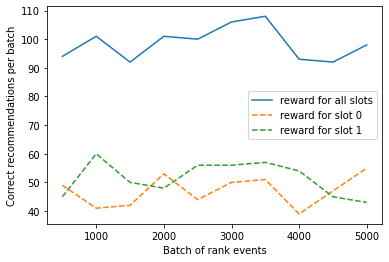

In [150]:
createChart(count2, total_rewards2, total_slot_rewards2)

## Review the second chart

The second chart should show a visible increase in Rank predictions aligning with user preferences. 

## Clean up resources

If you do not intend to continue the tutorial series, clean up the following resources:

* Delete your Azure Notebook project. 
* Delete your Personalizer resource. 